In [25]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, sys, joblib, json
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import EarlyStopping

sys.path.append('/mnt/wrkdir/gene_discovery2/')
mem = joblib.Memory(location = 'cache', verbose=0)


DATA_DIR = '/mnt/wrkdir/gene_discovery2/data/'
RAW_MERGED_FILE_NAME = f'{DATA_DIR}gene_data_merged_all.parquet'
NUMERIC_SCALED_MERGED_FILE_NAME = f'{DATA_DIR}gene_data_merged_all_NUMERIC_SCALED.parquet'
CURATED_GENES_FILE = '/mnt/wrkdir/gene_discovery2/data/trait_genes_category_June2019.csv'

if not 'numeric_scaled' in globals():
    numeric_scaled = pd.read_parquet(NUMERIC_SCALED_MERGED_FILE_NAME)
    genes = pd.read_csv(CURATED_GENES_FILE, encoding = 'unicode_escape')
    genes['category'] = genes['category'].replace('plant\xa0morphology\xa0trait', 'plant morphology trait')
    rel_genes = genes[genes['Entry'].isin(numeric_scaled.index)]
    numeric_genes = numeric_scaled.loc[rel_genes['Entry'].values, :].dropna()
    with open(f'{DATA_DIR}2019_06_14_test_train_gene_set.json', 'r') as f:
        train_data = json.load(f)
        train_set = train_data['train']
        test_set = train_data['test']
        

numeric_scaled.shape, rel_genes.shape, len(train_set), len(test_set), len(train_set) + len(test_set)

((992173, 3153), (367, 11), 221, 46, 267)

In [7]:
def encode_categories(df = rel_genes, idx='Entry', by='category', train_set=train_set, test_set=test_set):
    y = rel_genes[[idx, by]].copy()
    y['count'] = 1
    y = y.groupby([idx, by]).count().reset_index()
    y['count'] = 1
    y = y.pivot(idx, by, 'count').fillna(0)
    y_train = y.loc[train_set, :]
    y_test = y.loc[test_set, :]
    return y, y_train, y_test

def encode_features(y_train, y_test, numeric_scaled = numeric_scaled):
    x_train = numeric_scaled.loc[y_train.index, :]
    x_test = numeric_scaled.loc[y_test.index, :]
    return x_train, x_test

def present_accuracy_precision_recall(pred, y_test):
    results = []
    pred[pred > 0.5] = 1
    pred[pred < 0.5] = 0
    for i in range(y_test.shape[1]):
        acc = accuracy_score(pred[:, i], y_test.values[:, i])
        prec = precision_score(pred[:, i], y_test.values[:, i])
        recall = recall_score(pred[:, i], y_test.values[:, i])
        results.append((y_test.columns[i], acc, prec, recall))
        #print(f'accuracy for trait {y_test.columns[i]}: {acc:.4f}, precision={prec:.4f}')
    results = pd.DataFrame(results, columns=['trait', 'acc', 'precision', 'recall']).round(2)
    results.loc['mean'] = results.mean()
    return results

y, y_train, y_test = encode_categories()
x_train, x_test = encode_features(y_train=y_train, y_test=y_test)

print(y_test.shape, y_train.shape)
print(x_test.shape, x_train.shape)
assert np.any(y_test.index == x_test.index)
assert np.any(y_train.index == x_train.index)

(46, 10) (221, 10)
(46, 3153) (221, 3153)


# Try to use PCA to learn better representation of the data ...

### First, train pca on the BIG gene data ...

In [15]:
from sklearn.decomposition import PCA, IncrementalPCA
N_COMPONENTS = 200

if not 'pca' in globals():
    pca = PCA(n_components=N_COMPONENTS).fit(numeric_scaled.values)
x_train_pca = pca.transform(x_train.values)
x_test_pca = pca.transform(x_test.values)
x_train_pca.shape, x_test_pca.shape

((221, 200), (46, 200))

# test RandomForest performance of the PCA data...

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier


clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100))
clf.fit(x_train_pca, y_train.values)

pred = clf.predict(x_test_pca)
present_accuracy_precision_recall(pred, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


trait    acc  precision  recall
0                   abiotic stress trait  0.720      0.350   0.750
1                      biochemical trait  0.890      0.000   0.000
2               biological process trait  0.960      0.000   0.000
3                    biotic stress trait  0.780      0.000   0.000
4     plant growth and development trait  0.650      0.000   0.000
5                 plant morphology trait  0.610      0.060   0.500
6                    plant quality trait  1.000      0.000   0.000
7                      plant vigot trait  0.980      0.000   0.000
8           sterility or fertility trait  0.890      0.000   0.000
9                            yield trait  1.000      0.000   0.000
mean                                 NaN  0.848      0.041   0.125

# test Deep-learning performance of PCA data

In [26]:


def get_model(inp_size,
              layers_depth = 5,
              layers_width = 200,
              out_size=y_train.shape[1]):
    
    inp = Input(batch_shape = (None, inp_size))
    x = Dense(layers_width, activation='relu')(inp)
    for i in range(layers_depth - 1):
        x = Dense(layers_width, activation='relu')(x)
        x = BatchNormalization()(x)
    
    x = Dense(out_size, activation='sigmoid')(x)
    model = Model(inp, x)
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

model = get_model(x_train_pca.shape[1])
model.fit(x_train_pca, y_train.values, epochs=1000, callbacks=[EarlyStopping(monitor='loss', patience=100)])

train_loss, train_acc = model.evaluate(x_train_pca, y_train.values)
test_loss, test_acc = model.evaluate(x_test_pca, y_test.values)

clear_output()

pred = model.predict(x_test_pca)
present_accuracy_precision_recall(pred, y_test)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


trait    acc  precision  recall
0                   abiotic stress trait  0.720      0.350   0.750
1                      biochemical trait  0.890      0.000   0.000
2               biological process trait  0.960      0.000   0.000
3                    biotic stress trait  0.830      0.000   0.000
4     plant growth and development trait  0.630      0.000   0.000
5                 plant morphology trait  0.630      0.060   1.000
6                    plant quality trait  1.000      0.000   0.000
7                      plant vigot trait  0.980      0.000   0.000
8           sterility or fertility trait  0.800      0.000   0.000
9                            yield trait  1.000      0.000   0.000
mean                                 NaN  0.844      0.041   0.175

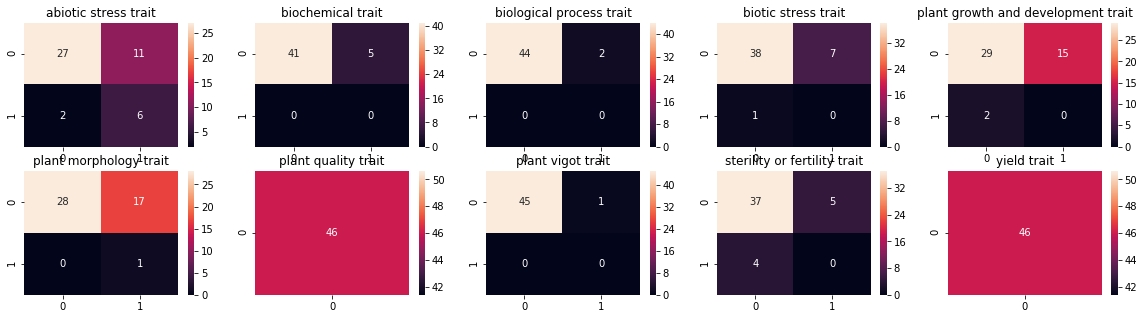

In [68]:
def draw_heat_maps(pred, y_test):

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    plt.figure(figsize=[20,5])
    #fig, axes =plt.subplots(2, 5)
    for idx, col in enumerate(y_test.columns):
        mtx = confusion_matrix(pred[:, idx], y_test[col].values)
        try:
            mtx = pd.DataFrame(mtx, columns=[0,1], index=[0,1])
        except: 
            mtx = pd.DataFrame(mtx)
        plt.subplot(2, 5, idx+1)
        plt.title(col)
        sns.heatmap(mtx, annot=True)
        
draw_heat_maps(pred, y_test)    

# can you improve performance with resnet structure ?

trait    acc  precision  recall
0                   abiotic stress trait  0.720      0.350   0.750
1                      biochemical trait  0.870      0.000   0.000
2               biological process trait  0.960      0.000   0.000
3                    biotic stress trait  0.850      0.000   0.000
4     plant growth and development trait  0.630      0.000   0.000
5                 plant morphology trait  0.610      0.060   0.500
6                    plant quality trait  1.000      0.000   0.000
7                      plant vigot trait  0.980      0.000   0.000
8           sterility or fertility trait  0.870      0.000   0.000
9                            yield trait  1.000      0.000   0.000
mean                                 NaN  0.849      0.041   0.125

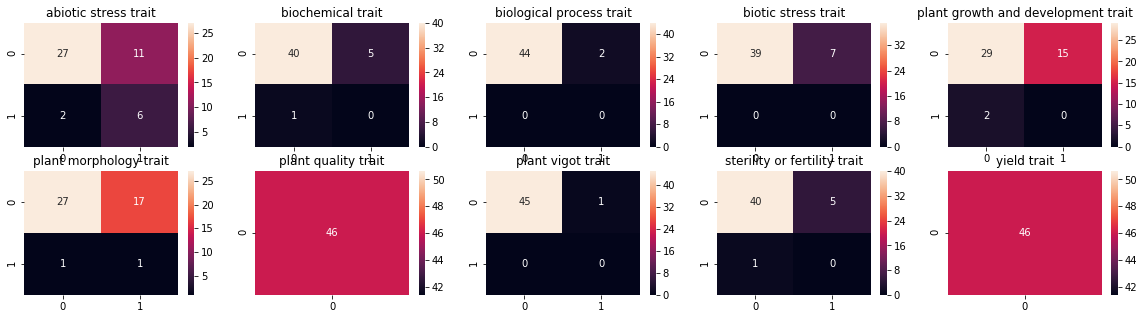

In [78]:
from keras.layers import Add, Dropout
def get_resnet_model(inp_size,
              layers_depth = 5,
              layers_width = 500,
              out_size=y_train.shape[1],
              dropout=0.0):
    
    inp = Input(batch_shape = (None, inp_size))
    x = Dense(layers_width, activation='relu')(inp)
    
    for i in range(layers_depth - 1):
        x2 = Dense(layers_width, activation='relu')(x)
        x2 = BatchNormalization()(x2)
        x2 = Dropout(dropout)(x2)
        x = Add()([x, x2]) # This is the resnet part ...
    
    x = Dense(out_size, activation='sigmoid')(x)
    model = Model(inp, x)
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

model = get_resnet_model(x_train_pca.shape[1])
print(model.summary())
model.fit(x_train_pca, y_train.values, epochs=10000, callbacks=[EarlyStopping(monitor='loss', patience=100)])

train_loss, train_acc = model.evaluate(x_train_pca, y_train.values)
test_loss, test_acc = model.evaluate(x_test_pca, y_test.values)

clear_output()

pred = model.predict(x_test_pca)
display(present_accuracy_precision_recall(pred, y_test))
draw_heat_maps(pred, y_test)